In [1]:
import pandas as pd
import numpy as np
import os
import os.path

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as snsplt
os.environ['PROJ_LIB'] = '/anaconda3/pkgs/proj4/share/proj'
# from mpl_toolkits.basemap import Basemap

import matplotlib.cm
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import seaborn as sns

from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

from sklearn.ensemble import BaggingClassifier
from sklearn import tree

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegressionCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.getcwd()

'/Users/poojatyagi/Dropbox (MIT)/CS109_project_data'

In [151]:
# comb_data=pd.read_csv("/Users/poojatyagi/Dropbox (MIT)/CS109_project_data/Usefuldata/combined_data.csv")
local_data_folder = "/Users/colleendriscoll/Dropbox/Classes/CS 109A/CS 109A Final project/data/"
comb_data = pd.read_csv(local_data_folder + "combined_data.csv")
comb_data.head()

,year,dist_id,dem_vote_share,congress,icpsr,nominate_dim1,nominate_dim2,nokken_poole_dim1,nokken_poole_dim2,age,...,senate,median_HH_income,median_age,mortgage_cost,unemp_rate,bachelor_deg_perc,black_perc,HS_diploma_perc,white_perc,redistricted
0,2006,AK_1,0.414254,109.0,14066.0,0.279,0.014,0.367,-0.047,73.0,...,0.484848,25793.0,33.5,1015.0,9.4,0.107839,0.032051,0.177972,0.686767,0.0
1,2008,AK_1,0.472837,110.0,14066.0,0.279,0.014,0.291,0.269,75.0,...,0.500000,30271.0,33.0,1166.0,7.7,0.108886,0.036257,0.164006,0.691129,0.0
2,2010,AK_1,0.306755,111.0,14066.0,0.279,0.014,0.242,0.642,77.0,...,0.581633,28202.0,33.8,1167.0,9.6,0.116734,0.034610,0.159744,0.674308,0.0
3,2012,AK_1,0.309172,112.0,14066.0,0.279,0.014,0.338,-0.052,79.0,...,0.520408,29932.0,33.8,1239.0,7.8,0.108769,0.035829,0.178108,0.665188,0.0
4,2014,AK_1,0.445620,113.0,14066.0,0.279,0.014,0.265,0.116,81.0,...,0.540816,31557.0,33.3,1258.0,7.6,0.116235,0.033649,0.179152,0.656391,0.0


In [154]:
midterm_binary = [0 if comb_data.year[i] % 4 ==0 else 1\
                  for i in range(len(comb_data))]
comb_data['midterm'] = midterm_binary

In [156]:
(comb_data).columns

Index(['year', 'dist_id', 'dem_vote_share', 'congress', 'icpsr',
       'nominate_dim1', 'nominate_dim2', 'nokken_poole_dim1',
       'nokken_poole_dim2', 'age', 'dem_incumbent', 'dem_prior_vote_share',
       'president', 'house', 'senate', 'median_HH_income', 'median_age',
       'mortgage_cost', 'unemp_rate', 'bachelor_deg_perc', 'black_perc',
       'HS_diploma_perc', 'white_perc', 'redistricted', 'midterm'],
      dtype='object')

In [157]:
#Test Data = Data for year 2018
testdata=comb_data[comb_data.year==2018]

#Train Data = Data for years other than 2018
traindata=comb_data[comb_data.year!=2018]

testdata.shape, traindata.shape

((435, 25), (2597, 25))

In [158]:
#List of predictors we want to use
predictors=['year','nokken_poole_dim1', 'nokken_poole_dim2', 'age',
            'dem_incumbent', 'dem_prior_vote_share',
            'president', 'house', 'senate', 'median_HH_income',
            'median_age', 'mortgage_cost', 'unemp_rate',
            'bachelor_deg_perc', 'black_perc',
            'HS_diploma_perc', 'white_perc',
            'redistricted', 'midterm']

#Columns to drop in Xtest and Xtrain
columns_to_drop=set(comb_data.columns) - set(predictors)

In [159]:
#Response Variable for test and train data sets = Democrat Vote Share
ytest=testdata.dem_vote_share
ytrain=traindata.dem_vote_share


#Xdata for test and train data
xtest=testdata.drop(columns_to_drop, axis=1, inplace = False)
xtrain=traindata.drop(columns_to_drop, axis=1, inplace = False)

In [160]:
ytrain.shape, xtrain.shape

((2597,), (2597, 19))

In [161]:
corr_table_cols_to_drop = ['dist_id', 'congress', 'icpsr',
                          'nominate_dim1', 'nominate_dim2']
corr_table_data = comb_data.drop(corr_table_cols_to_drop,
                                axis = 1, inplace = False)
## Reordering columns
corr_table_data = corr_table_data[['year', 'dem_vote_share',
                                   'dem_prior_vote_share', 
                                   'dem_incumbent',
                                   'redistricted',
                                   'midterm',
                                   'president', 'house',
                                   'senate', 'nokken_poole_dim1',
                                   'nokken_poole_dim2', 'age',
                                   'white_perc', 'black_perc',
                                   'HS_diploma_perc',
                                   'bachelor_deg_perc',
                                   'unemp_rate', 'mortgage_cost',
                                   'median_HH_income', 'median_age']]

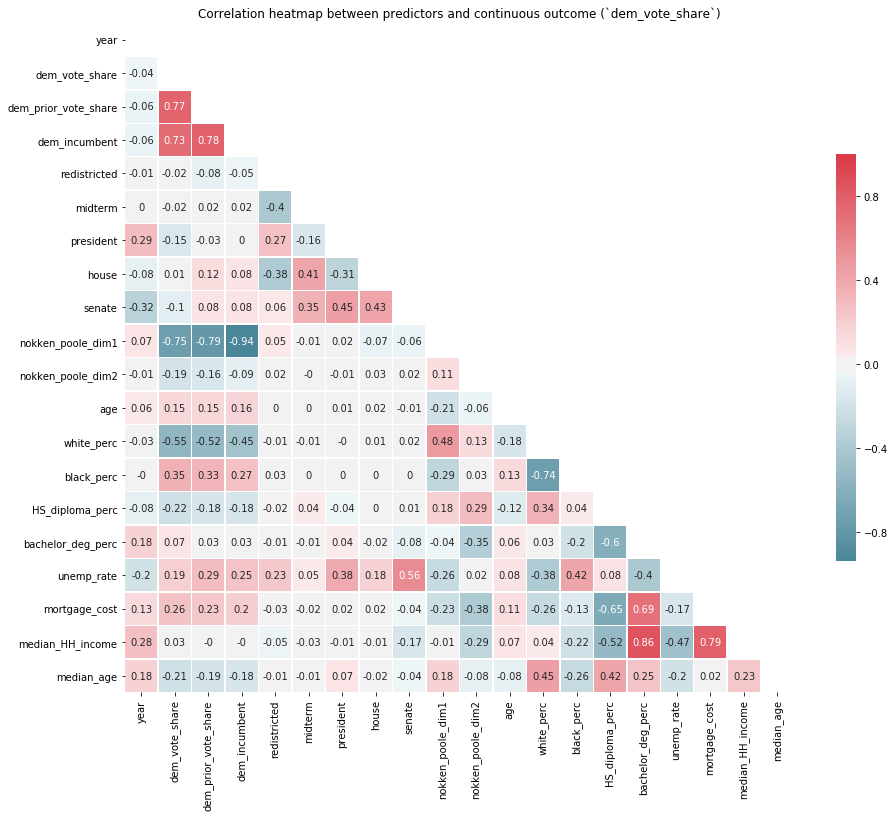

In [162]:
mask = np.zeros_like(corr_table_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(np.round(corr_table_data.corr(), 2),
            mask=mask, cmap=cmap,
            center=0,annot=True,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})
ax.set_title('Correlation heatmap between predictors and \
continuous outcome (`dem_vote_share`)')
plt.show();

In [163]:
#Convert the dem_vote_share to binary output
def get_binary(response):
    binary=[]
    for i in range(len(response)):
        if response.iloc[i] <0.5:
            out=0 
        else:
            out = 1 
        binary.append(out)
    binary=pd.DataFrame(binary)
    return binary

In [164]:
#binary response data
binarytest=get_binary(ytest)
binarytrain=get_binary(ytrain)

In [165]:
# Fit logistic regression on training data 

from sklearn.linear_model import LogisticRegression

logreg1 = LogisticRegression( C=100000)
logreg1.fit(xtrain, binarytrain)

# Make Prediction and check the accuracy
y_test_probs=(logreg1.predict_proba(xtest))
y_train_probs=(logreg1.predict_proba(xtrain))

logreg1_testscore=logreg1.score(xtest, binarytest)
logreg1_trainscore=logreg1.score(xtrain, binarytrain)

print('Accuracy of logistic regression classifier on \
train set: {0:.2f}%'.format(logreg1_trainscore*100))
print('Accuracy of logistic regression classifier on \
test set: {0:.2f}%'.format(logreg1_testscore*100))

Accuracy of logistic regression classifier on train set: 90.99%
Accuracy of logistic regression classifier on test set: 89.66%


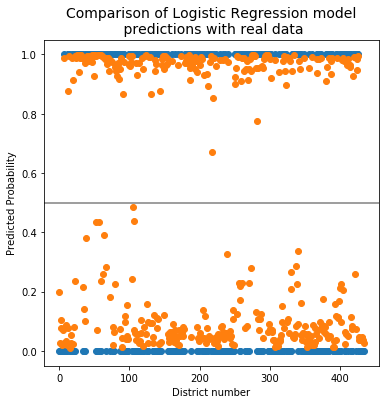

In [11]:
fig1,ax1=plt.subplots(figsize=[6,6])
plt.plot(binarytest,'o',label = "True results")
plt.plot(y_test_probs[:,1],'o', label ="Prediction")
plt.xlabel("District number")
plt.ylabel("Predicted Probability")
plt.axhline(0.5, color="gray")
plt.title("Comparison of Logistic Regression model\n predictions with real data",
          fontsize=14);

In [166]:
scoretrain=[]
scoretest=[]
for i in range(1,25,2):
    RF1= RandomForestClassifier(max_depth=i, n_estimators=40)
    RF1.fit(xtrain, binarytrain)
    scoretrain.append(accuracy_score(binarytrain,  RF1.predict(xtrain)))
    scoretest.append(accuracy_score(binarytest,  RF1.predict(xtest)))

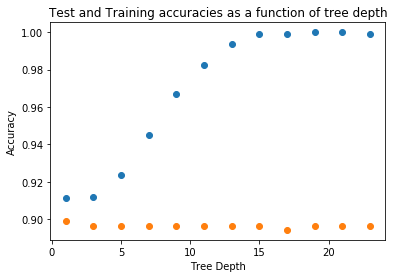

In [167]:
plt.plot(range(1,25,2), scoretrain,'o')
plt.plot(range(1,25,2), scoretest,'o')
plt.title("Test and Training accuracies as a function of tree depth")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy");

In [168]:
#The best tree depth = 3
RF2= RandomForestClassifier(max_depth=15, n_estimators=40)
RF2.fit(xtrain, binarytrain)

y_predRF_train = RF2.predict(xtrain)
y_predRF_test = RF2.predict(xtest)

#Perfromance Evaluation
trainRF_score = accuracy_score(binarytrain, y_predRF_train)
testRF_score = accuracy_score(binarytest, y_predRF_test)

print("Random Forest Accuracy, Training Set : {0:.2f}%".format(trainRF_score*100))
print("Random Forest Accuracy, Testing Set: {0:.2f}%".format(testRF_score*100))

Random Forest Accuracy, Training Set : 99.73%
Random Forest Accuracy, Testing Set: 89.66%


In [169]:
#Bagging Classifier
bag1 = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
bag1.fit(xtrain, binarytrain)
bag1_trainscore=bag1.score(xtrain,binarytrain)
bag1_testscore=bag1.score(xtest,binarytest)
print("Bagging Accuracy, Training Set : {0:.2f}%"\
      .format(bag1_trainscore*100))
print("Bagging Accuracy, Testing Set: {0:.2f}%"
      .format(bag1_testscore*100))

Bagging Accuracy, Training Set : 99.54%
Bagging Accuracy, Testing Set: 89.66%


In [170]:
#Scale Data to have mean = 1 and std =1
#Ridge regression on Scaled Data
xtrain_scaled=pd.DataFrame(preprocessing.scale(xtrain))
xtest_scaled=pd.DataFrame(preprocessing.scale(xtest))
ridge1= linear_model.Ridge(alpha=0.5)
ridge1.fit(xtrain,ytrain)

ridge1_testpred=pd.Series(ridge1.predict(xtest))
binarytest_ridgepred=get_binary(ridge1_testpred)

ridge1_trainpred=pd.Series(ridge1.predict(xtrain))
binarytrain_ridgepred=get_binary(ridge1_trainpred)


ridge1_testscore=accuracy_score(binarytest_ridgepred,binarytest)
ridge1_trainscore=accuracy_score(binarytrain_ridgepred,binarytrain)

print("Ridge Accuracy, Training Set : {0:.2f}%"\
      .format(ridge1_trainscore*100))
print("Ridge Accuracy, Testing Set: {0:.2f}%"\
      .format(ridge1_testscore*100))

Ridge Accuracy, Training Set : 91.41%
Ridge Accuracy, Testing Set: 90.11%


In [171]:
#Logistic Regression with cross-validation and L1 regularization (Lasso)

logregcv1 = LogisticRegressionCV(cv=5, penalty='l1',
                                 solver='liblinear').fit(xtrain, binarytrain)
logregcvlasso_testscore= logregcv1.score(xtest, binarytest) 
logregcvlasso_trainscore= logregcv1.score(xtrain, binarytrain) 

print("Lasso with CV Accuracy, Training Set : {0:.2f}%"\
      .format(logregcvlasso_trainscore*100))
print("Lasso with CV Accuracy, Testing Set: {0:.2f}%"\
      .format(logregcvlasso_testscore*100))

Lasso with CV Accuracy, Training Set : 91.45%
Lasso with CV Accuracy, Testing Set: 89.66%


In [172]:
#Logistic Regression with cross-validation and L2 regularization (Ridge)

logregcv2 = LogisticRegressionCV(cv=5, penalty='l2').fit(\
    xtrain, binarytrain)

logregcvridge_testscore= logregcv2.score(xtest, binarytest) 
logregcvridge_trainscore= logregcv2.score(xtrain, binarytrain) 

print("Ridge with CV Accuracy, Training Set : {0:.2f}%"\
      .format(logregcvridge_trainscore*100))
print("Ridge with CV Accuracy, Testing Set: {0:.2f}%"\
      .format(logregcvridge_testscore*100))

Ridge with CV Accuracy, Training Set : 75.86%
Ridge with CV Accuracy, Testing Set: 75.86%


In [173]:
accuracies_table = {'classifier':['Logistic Regression',
                                  'Logistic Regression with CV (Lasso)',
                                  'Logistic Regression with CV (Ridge)',
                                  'Linear Regression (Ridge)','Bagging',
                                  'Random Forest'],                    
                    'training accuracy':[logreg1_trainscore,
                                         logregcvlasso_testscore,
                                         logregcvridge_trainscore,
                                         ridge1_trainscore,                    
                                         bag1_trainscore,
                                         trainRF_score],
                    'test accuracy':[logreg1_testscore,
                                     logregcvlasso_testscore, 
                                     logregcvridge_testscore,
                                     ridge1_testscore,
                                     bag1_testscore,
                                     testRF_score]}

accuracies_table_df = pd.DataFrame(accuracies_table)

print("Summary of Models used:")
accuracies_table_df

Summary of Models used:


,classifier,training accuracy,test accuracy
0,Logistic Regression,0.909896,0.896552
1,Logistic Regression with CV (Lasso),0.896552,0.896552
2,Logistic Regression with CV (Ridge),0.758568,0.758621
3,Linear Regression (Ridge),0.914132,0.901149
4,Bagging,0.995379,0.896552
5,Random Forest,0.997305,0.896552


In [174]:
#Add Interaction Terms
poly = PolynomialFeatures(degree=3, interaction_only=False)
xtrain_interact=poly.fit_transform(xtrain)
xtest_interact=poly.fit_transform(xtest)

In [175]:
#Fit Logistic regression with interaction terms
logreg2 = LogisticRegression(C=1)
logreg2.fit(xtrain_interact, binarytrain)

# Make Prediction and check the accuracy
y_test_probs2=(logreg2.predict_proba(xtest_interact))
y_train_probs2=(logreg2.predict_proba(xtrain_interact))

logreg2_testscore=logreg2.score(xtest_interact, binarytest)
logreg2_trainscore=logreg2.score(xtrain_interact, binarytrain)

print('Accuracy of logistic regression classifier on train set: {0:.2f}%'\
      .format(logreg2_trainscore*100))
print('Accuracy of logistic regression classifier on test set: {0:.2f}%'\
      .format(logreg2_testscore*100))

Accuracy of logistic regression classifier on train set: 91.30%
Accuracy of logistic regression classifier on test set: 89.43%


In [176]:
logreg2_testscore

0.8942528735632184

In [70]:
third_degree_feature_names = poly.get_feature_names()
pd.Series(third_degree_feature_names).to_csv("third_degree_feature_names.csv")
third_degree_coefs = \
pd.read_csv(local_data_folder + "third_degree_feature_names_corrected.csv")

In [79]:
third_degree_coefs['coef'] = np.round(logreg2.coef_[0]*(10**10), 2)
third_degree_coefs['abs_coef'] = np.abs(third_degree_coefs.coef)
third_degree_coefs = third_degree_coefs.sort_values('abs_coef',
                                                    ascending=False)

In [82]:
third_degree_coefs[:20]

,var_name,coef,abs_coef
915,dem_prior_vote_share senate unemp_rate,58.27,58.27
517,nokken_poole_dim2^2 dem_prior_vote_share,-53.51,53.51
33,year black_perc,-53.50,53.50
788,dem_incumbent dem_prior_vote_share median_HH_i...,26.65,26.65
546,nokken_poole_dim2 dem_incumbent dem_prior_vote...,-23.13,23.13
410,nokken_poole_dim1 dem_incumbent dem_prior_vote...,-23.10,23.10
939,dem_prior_vote_share mortgage_cost unemp_rate,-22.56,22.56
4,age,-17.59,17.59
504,nokken_poole_dim1 black_perc^2,15.46,15.46
592,nokken_poole_dim2 house HS_diploma_perc,15.28,15.28


In [177]:
## Test results
y_test_continuous = ytest
y_test = binarytest[0].values

y_test_predict_bool = (logreg2.predict(xtest_interact))
y_test_predict_cont = (logreg2.predict_proba(xtest_interact))

# Plot predicted probabilities
accurate_indices = np.where(y_test_predict_bool == y_test)
inaccurate_indices = np.where(y_test_predict_bool != y_test)


In [178]:
plot_cols = corr_table_data.columns.drop(['dem_vote_share', 'year',
                                         'president', 'house', 'senate',
                                         'midterm'])

len(plot_cols)

14

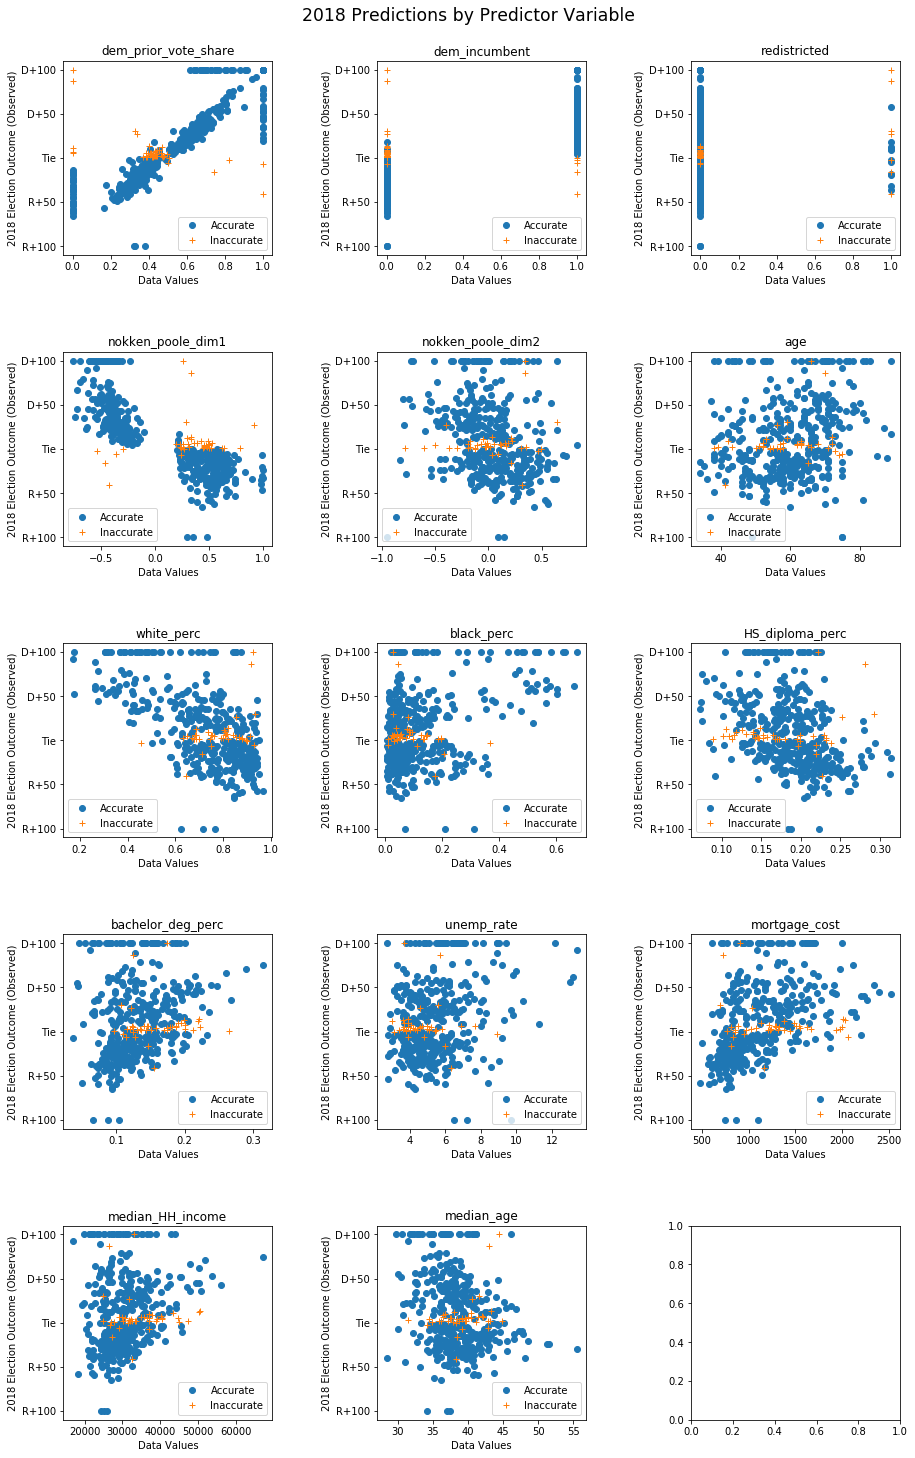

In [179]:
col_n, row_n = 3,5

fig, ax  = plt.subplots(nrows=row_n, ncols=col_n, figsize=(5*col_n,5*row_n))
fig.suptitle("2018 Predictions by Predictor Variable",
            y = 0.91, fontsize = "xx-large")
fig.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.5, hspace=0.5)
ax = ax.flatten()

for i, col in enumerate(plot_cols):
    x_values = xtest[col].values
    ## Data
    ax[i].plot(x_values[accurate],
             ytest.values[accurate], "o",
            label = "Accurate")
    ax[i].plot(x_values[inaccurate],
             ytest.values[inaccurate], "+",
            label = "Inaccurate")
    ax[i].set_title(col)
    ax[i].set_xlabel('Data Values')
    ax[i].set_ylabel('2018 Election Outcome (Observed)')
    ax[i].set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax[i].set_yticklabels(["R+100", "R+50", "Tie","D+50","D+100"])
    ax[i].legend()
plt.show();

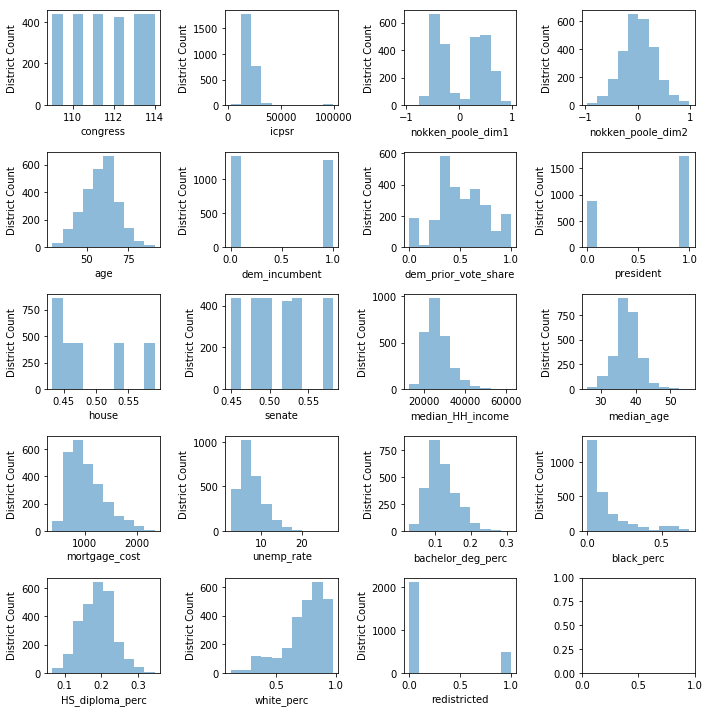

In [28]:
# fig.suptitle('Distribution of predictors across 435 districts (2017)', y=1.03)

labels=xtrain.columns

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(10,10))
ax = ax.flatten()

for i in range(xtrain.shape[1]):
    ax[i].hist(xtrain.iloc[:,i].dropna().astype(float), alpha=0.5)
    ax[i].set_ylabel('District Count')
    ax[i].set_xlabel(labels[i])
plt.tight_layout()